In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import json
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [16]:
import json

# Correct Windows path using raw string literals
files = [
    r"D:\Aditya\compoundV2_transactions_ethereum_chunk_0.json",
    r"D:\Aditya\compoundV2_transactions_ethereum_chunk_1.json",
    r"D:\Aditya\compoundV2_transactions_ethereum_chunk_2.json"
]

# Create master lists for each transaction type
all_deposits, all_borrows, all_repays, all_withdraws, all_liquidations = [], [], [], [], []

# Load and combine data
for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        all_deposits.extend(data.get("deposits", []))
        all_borrows.extend(data.get("borrows", []))
        all_repays.extend(data.get("repays", []))
        all_withdraws.extend(data.get("withdraws", []))
        all_liquidations.extend(data.get("liquidations", []))


In [17]:
import pandas as pd

deposits_df = pd.json_normalize(all_deposits)
borrows_df = pd.json_normalize(all_borrows)
repays_df = pd.json_normalize(all_repays)
withdraws_df = pd.json_normalize(all_withdraws)
liquidations_df = pd.json_normalize(all_liquidations)


In [18]:
def aggregate_amount(df, col_name='amountUSD'):
    df[col_name] = df[col_name].astype(float)
    return df.groupby('account.id')[col_name].sum().reset_index()


In [19]:
for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        print(f"{file}:")
        print("  deposits:", len(data.get("deposits", [])))
        print("  borrows:", len(data.get("borrows", [])))
        print("  repays:", len(data.get("repays", [])))
        print("  withdraws:", len(data.get("withdraws", [])))
        print("  liquidations:", len(data.get("liquidations", [])))
        print()



D:\Aditya\compoundV2_transactions_ethereum_chunk_0.json:
  deposits: 10000
  borrows: 10000
  repays: 10000
  withdraws: 10000
  liquidations: 0

D:\Aditya\compoundV2_transactions_ethereum_chunk_1.json:
  deposits: 10000
  borrows: 10000
  repays: 10000
  withdraws: 10000
  liquidations: 0

D:\Aditya\compoundV2_transactions_ethereum_chunk_2.json:
  deposits: 10000
  borrows: 10000
  repays: 10000
  withdraws: 10000
  liquidations: 0



In [21]:
all_deposits, all_borrows, all_repays, all_withdraws, all_liquidations = [], [], [], [], []

for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        all_deposits.extend(data.get("deposits", []))
        all_borrows.extend(data.get("borrows", []))
        all_repays.extend(data.get("repays", []))
        all_withdraws.extend(data.get("withdraws", []))
        all_liquidations.extend(data.get("liquidations", []))  # Will be empty, but that's fine



In [22]:
deposits_df = pd.json_normalize(all_deposits)
borrows_df = pd.json_normalize(all_borrows)
repays_df = pd.json_normalize(all_repays)
withdraws_df = pd.json_normalize(all_withdraws)
liquidations_df = pd.json_normalize(all_liquidations)


In [13]:
from sklearn.preprocessing import MinMaxScaler

wallets['raw_score'] = (
    (wallets['total_deposited_usd'] * 0.4) +
    (wallets['num_deposits'] * 0.3) +
    (wallets['token_variety'] * 0.3)
)

scaler = MinMaxScaler(feature_range=(0, 100))
wallets['score'] = scaler.fit_transform(wallets[['raw_score']])


In [25]:
# Aggregation function for amountUSD per wallet
def agg_amount(df, label):
    df['amountUSD'] = df['amountUSD'].astype(float)
    grouped = df.groupby('account.id')['amountUSD'].sum().reset_index()
    return grouped.rename(columns={'amountUSD': f'total_{label}_usd'})

# Aggregate transaction types
deposits = agg_amount(deposits_df, 'deposited')
borrows = agg_amount(borrows_df, 'borrowed')
repays = agg_amount(repays_df, 'repaid')
withdraws = agg_amount(withdraws_df, 'withdrawn')

# Count liquidations per wallet (safely handle empty DataFrame)
if not liquidations_df.empty and 'account.id' in liquidations_df.columns:
    liquidations = liquidations_df['account.id'].value_counts().reset_index()
    liquidations.columns = ['account.id', 'num_liquidations']
else:
    liquidations = pd.DataFrame(columns=['account.id', 'num_liquidations'])



In [31]:
# Step 6: Merge All Features
wallet_df = deposits \
    .merge(borrows, on='account.id', how='outer') \
    .merge(repays, on='account.id', how='outer') \
    .merge(withdraws, on='account.id', how='outer') \
    .merge(liquidations, on='account.id', how='left')

# Fill missing values and fix FutureWarning with infer_objects
wallet_df.fillna(0, inplace=True)
wallet_df = wallet_df.infer_objects(copy=False)  # ← This line prevents future type issues

# Rename wallet ID column
wallet_df.rename(columns={'account.id': 'wallet_id'}, inplace=True)





In [32]:
wallet_df['repay_ratio'] = wallet_df['total_repaid_usd'] / (wallet_df['total_borrowed_usd'] + 1e-6)
wallet_df['deposit_to_borrow_ratio'] = wallet_df['total_deposited_usd'] / (wallet_df['total_borrowed_usd'] + 1e-6)
wallet_df['net_deposit'] = wallet_df['total_deposited_usd'] - wallet_df['total_withdrawn_usd']


In [33]:
from sklearn.preprocessing import MinMaxScaler

# Compute raw score with weighted behavior
wallet_df['raw_score'] = (
    (wallet_df['repay_ratio'] * 40) +
    (wallet_df['deposit_to_borrow_ratio'] * 30) +
    (wallet_df['net_deposit'] * 0.001) -  # net deposit scaled down
    (wallet_df['num_liquidations'] * 10)  # if liquidations existed
)

# Normalize raw score to a 0–100 scale
scaler = MinMaxScaler(feature_range=(0, 100))
wallet_df['score'] = scaler.fit_transform(wallet_df[['raw_score']])


In [34]:
top_1000 = wallet_df[['wallet_id', 'score']].sort_values(by='score', ascending=False).head(1000)
top_1000.to_csv("D:/Aditya/top_1000_wallets_final.csv", index=False)


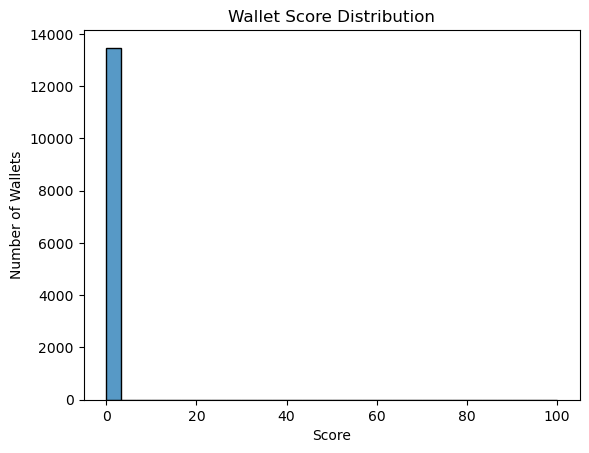

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(wallet_df['score'], bins=30)
plt.title("Wallet Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Wallets")
plt.show()


In [36]:
top_1000 = wallet_df[['wallet_id', 'score']].sort_values(by='score', ascending=False).head(1000)
top_1000.to_csv("D:/Aditya/top_1000_wallets_final.csv", index=False)
